If the ModuleCheck ran without any issue, run this to make sure the entire model works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import astropy
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import default_cosmology

In [2]:
# Plot Styling
plt.style.use('dark_background')
plt.rcParams.update({
    'font.family':'serif', 'mathtext.fontset':'dejavuserif',
    'axes.grid':True, 'grid.linestyle': ':', 'grid.alpha': 0.5,
    'xtick.direction':'in', 'xtick.minor.visible': True, 'xtick.top':True,
    'ytick.direction':'in', 'ytick.minor.visible': True, 'ytick.right':True,
    'figure.figsize': [9, 6], 'axes.titlesize':30, 'legend.fontsize': 15, 'legend.title_fontsize': 20,
    'axes.labelsize':25, 'xtick.labelsize':15, 'ytick.labelsize':15
})

To start, we specify all of the modules we tested in modulecheck.ipynb in a big dictionary, which we then fetch.

In [3]:
from Models import SHMRs, HaloModels, HODs, SMFs

fmoddict = {
    'SHMR': {
        'name':'Kravstov2014', 
        'spefs': {
            'sample':'M200c'}},
    'HMF': {
        'name':'pyccl', 
        'spefs': {
            'mfunc':'Tinker08', 
            'mdef':'200c', 
            'hbias':'Tinker10'}},
    'SMF': {
        'name': 'BOSSDR10', 
        'spefs': {
            'galaxy':'CMASS', 
            'group':'portsmouth', 
            'template':'passive', 
            'IMF':'Kroupa'}},
    'HOD': {
        'name':'Kou2023', 
        'spefs': {
            'sample':'M*>10.8'}},}

hod = getattr(HODs, fmoddict['HOD']['name'])(fmoddict['HOD']['spefs'])
shmr = getattr(SHMRs, fmoddict['SHMR']['name'])(fmoddict['SHMR']['spefs'])
smf = getattr(SMFs, fmoddict['SMF']['name'])(fmoddict['SMF']['spefs'])
hmod = getattr(HaloModels, fmoddict['HMF']['name'])(fmoddict['HMF']['spefs'])

We also specify the data and profile models we're fitting to that data

In [4]:
from Models import Profiles, Data, Dust

tSZdict = {
    'data': {
        'name':'Schaan2021', 
         'spefs': {
             'freq': '150', 
             'sample':'cmass'}},
    'onehalo': {
        'name':'Amodeo2021', 
         'spefs': {
             'model':'GNFW'}},
    'twohalo': {
        'name':'Amodeo2021', 
         'spefs': {
             'model':'GNFW'}},
    'dust': {
        'name':'Amodeo2021',
        'spefs': {
            'model':'ACT+Hershel'}}}

# Define a pressure and dust profile
Pth1h = getattr(Profiles, tSZdict['onehalo']['name'])(tSZdict['onehalo']['spefs'])
Pth2h = getattr(Profiles, tSZdict['twohalo']['name'])(tSZdict['twohalo']['spefs'])
tSZmeas = getattr(Data, tSZdict['data']['name'])(tSZdict['data']['spefs'])
tSZdust = getattr(Dust, tSZdict['dust']['name'])(tSZdict['dust']['spefs'])

In [5]:
kSZdict = {
    'data': {
        'name':'Schaan2021', 
         'spefs': {
             'freq': '150', 
             'sample':'cmass'}},
    'onehalo': {
        'name':'Amodeo2021', 
        'spefs': {
            'model':'GNFW'}},
    'twohalo': {
        'name':'Amodeo2021', 
        'spefs': {
            'model':'GNFW'}},}

rho1h = getattr(Profiles, kSZdict['onehalo']['name'])(kSZdict['onehalo']['spefs'])
rho2h = getattr(Profiles, kSZdict['twohalo']['name'])(kSZdict['twohalo']['spefs'])
kSZmeas = getattr(Data, kSZdict['data']['name'])(kSZdict['data']['spefs'])

Fixed cosmology parameters are defined in the parameters block of the yaml file and need to be extracted

In [6]:
params = {
    "hh": {
        "value": 0.7},
    "Omega_L": {
        "value": 0.75},
    "Omega_m": {
        "value": 0.25},
    "Omega_b": {
        "value": 0.044},
    "T_CMB": {
        "value": 2.725},
    "XH": {
        "value": 0.76},        # hydrogen fraction
    "v_rms": {
        "value": 1.06e-3}   # v_rms/c, used for kSZ
}

cpars = {k: v["value"] for k, v in params.items() if isinstance(v, dict) and "value" in v}  

We need to define our radius, redshift, and mass arrays, the latter of the two being informed by our SMF

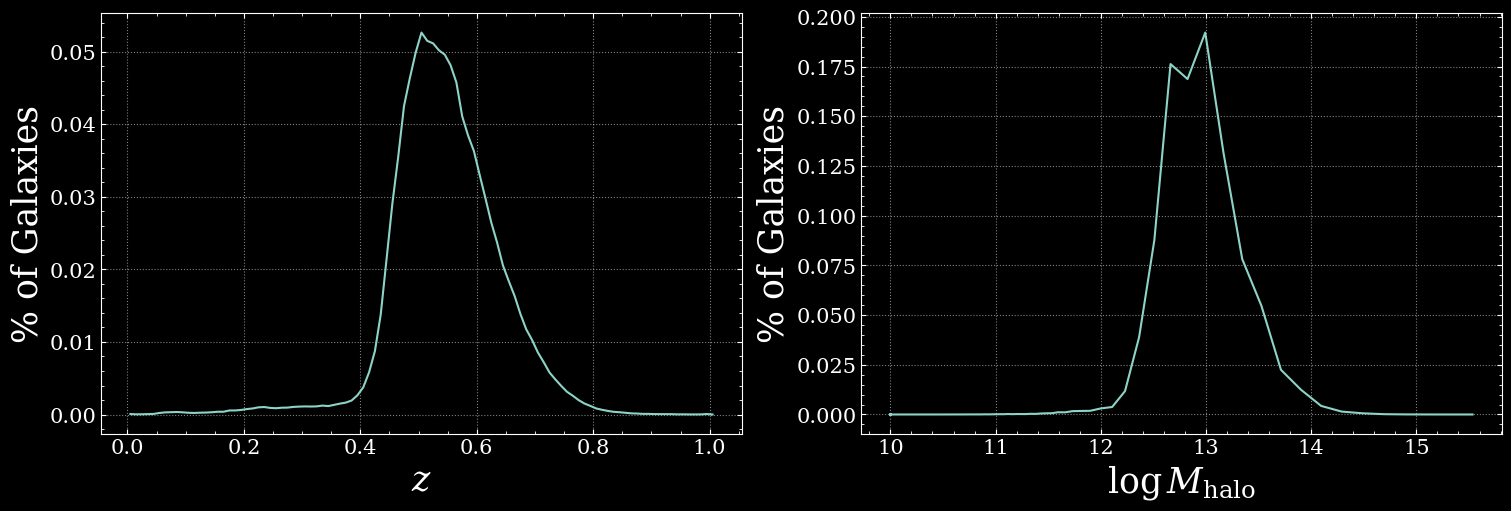

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

Ndist = smf.N()

axs[0].plot(smf.z, np.sum(Ndist, axis=1)/Ndist.sum())
axs[1].plot(shmr.SHMR(smf.logmstar)(), np.sum(Ndist, axis=0)/Ndist.sum())

axs[0].set(xlabel=r'$z$', ylabel=r'% of Galaxies')
axs[1].set(xlabel=r'$\log M_\text{halo}$', ylabel=r'% of Galaxies')

plt.show()

In [8]:
# Radial bins are chosen somewhat arbitrarily here
rs = np.logspace(-1.5, 1.5, 100)

# Add limits and bins for redshift and mass
zbins = np.linspace(0.4, 0.8, 21)
logmhalobins = np.linspace(12, 14, 51)

# Get the SMF and distributions, and the z and mstar arrays
hmf_smf = smf.SMF_to_HMF(logmhalobins, shmr.SHMR, zbins=zbins, **cpars)
ndist = smf.Ndist_halo(logmhalobins, shmr.SHMR, zbins=zbins, **cpars)
zs, logmhalos = smf.z, smf.logmhalo

We need some basic cosmological values that aren't defined in the modules, so let's just fetch those from astropy. These are all defined as functions now but will be calculated once we define our distance, redshift, and mass arrays.

In [19]:
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars['T_CMB'], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])

Hs = cosmology.H(zs).to(u.km/u.s/u.Mpc).value
rhocs = cosmology.critical_density(zs).to(u.Msun/u.Mpc**3).value
dAs = cosmology.angular_diameter_distance(zs).value
r200cs = (10**logmhalos/(4/3*np.pi*200*rhocs[:, None]))**(1/3)
chis = cosmology.comoving_distance(zs).value

# We'll also need average angular diameter distance for the projection later
zave = np.sum(smf.N()*smf.z[:, None])/smf.N().sum()
dA_ave = cosmology.angular_diameter_distance(zave).value

We'll also need FFT and IFFT functions.

In [10]:
from Models import FFTs

fft = FFTs.mcfit_package(rs)
ks = fft.ks

With mass and redshift we can calculate more complicated cosmological values we get from our modules

In [11]:
hmf_hmod = hmod.HMF(zs, logmhalos, **cpars)
bhs = hmod.bh(zs, logmhalos, **cpars)
Plins = hmod.Plin(ks, zs, **cpars)

We define our profiles, both the one-halo and two-halo component, and then sum to get the total. These can also be replaced with any input array of profile, so long as it matches the formatting and mass/redshift dimensionalities.

In [12]:
Pth = lambda params={}: Pth1h.Pth1h(rs, zs, logmhalos, rhocs, r200cs, **cpars)(params) + Pth2h.Pth2h(rs, zs, logmhalos, rhocs, r200cs, Plins, bhs, hmf_hmod,fft.FFT3D, fft.IFFT3D, ks, **cpars)(params)[..., None]

rho = lambda params={}: rho1h.rho1h(rs, zs, logmhalos, rhocs, r200cs, **cpars)(params) + rho2h.rho2h(rs, zs, logmhalos, rhocs, r200cs, Plins, bhs, hmf_hmod, fft.FFT3D, fft.IFFT3D, ks, **cpars)(params)[..., None]

Average profiles can be calculated simply with just a weighted average using the galaxy distribution

In [13]:
gdist_norm = ndist/np.sum(ndist)
aveprof_dist = lambda Pths: np.sum(np.sum(Pths*gdist_norm, axis=1), axis=1)

Or we can use the HOD method to obtain an average profile

In [22]:
from Models import Spectra
importlib.reload(Spectra)

Nc, Ns = hod.Nc(logmhalos), hod.Ns(logmhalos)
uck, usk = hod.uck(), hod.usk(rs, r200cs, fft.FFT3D)

aveprof_hod = Spectra.HODweighting(Nc, Ns, uck, usk, logmhalos, hmf_hmod, fft.FFT3D, fft.IFFT1D, np.sum(ndist, axis=1), **cpars)

With an average profile, we can project and convolve it with a beam to get a final predicted signal

In [15]:
from Models import Projections
importlib.reload(Projections)

tSZproj = Projections.project_Hankel(rs, tSZmeas.thetas, dA_ave, tSZmeas.beam_data, tSZmeas.beam_ells, tSZmeas.resp_data, tSZmeas.resp_ells)
tSZsign = lambda prof: Projections.Pth_to_muK(freq=tSZmeas.freq, **cpars)(tSZproj(prof)) + tSZdust.dust_uKarcmin(tSZmeas.thetas, int(tSZmeas.freq))()

kSZproj = Projections.project_Hankel(rs, kSZmeas.thetas, dA_ave, kSZmeas.beam_data, kSZmeas.beam_ells, kSZmeas.resp_data, kSZmeas.resp_ells)
kSZsign = lambda prof: Projections.rho_to_muK(freq=kSZmeas.freq, **cpars)(kSZproj(prof))

Now with all of our forward model functions defined, the process of going from any input profile is simple and easy, and only dependent on some input profile (and HOD parameters if using that method). The profile can be from some model dependant on some parameters, or could be just some array from a simulation or such

In [ ]:
rhos_sim = np.array([0.00000000e+00, 0.00000000e+00, 3.23705634e-27, 1.56168858e-27,
       4.91244157e-27, 5.21580669e-27, 6.38216246e-27, 5.70257482e-27,
       4.12217423e-27, 2.33994805e-27, 1.27096728e-27, 8.04106407e-28,
       3.44132275e-28, 2.88597645e-28, 1.87161756e-28, 2.24149017e-28,
       2.29002389e-28, 2.29382382e-28, 2.43134868e-28, 1.86100842e-28,
       2.86294376e-28, 1.81634456e-28, 2.16678369e-28, 2.19674323e-28,
       2.36151784e-28, 2.43873184e-28, 1.41361124e-28, 1.41445148e-28,
       1.22321137e-28, 1.06014661e-28, 7.01056510e-29, 4.03953593e-29,
       3.15549963e-29, 2.17803688e-29, 1.68568303e-29, 1.13405189e-29,
       7.89355462e-30, 4.38655348e-30, 3.12446110e-30, 2.37524525e-30,
       1.97745749e-30, 2.14973063e-30, 3.32091724e-30, 1.93460365e-30,
       2.53382894e-30, 2.02206927e-30, 1.54370781e-30, 1.35169049e-30,
       1.34329254e-30, 1.20058152e-30])

pths_sim = np.array([0.00000000e+00, 0.00000000e+00, 2.05314805e-12, 6.94251223e-13,
       2.86421140e-12, 1.97639960e-12, 6.43160187e-12, 1.77639342e-12,
       2.20108092e-12, 6.59821541e-13, 5.43241396e-13, 7.55490390e-14,
       9.40319103e-14, 4.08399105e-14, 3.33190822e-14, 3.19031824e-14,
       5.08679567e-14, 4.13141708e-14, 5.63702278e-14, 5.07182323e-14,
       6.17000004e-14, 6.61052150e-14, 7.84620564e-14, 8.55376704e-14,
       7.64423241e-14, 5.40675911e-14, 3.72300205e-14, 3.23169410e-14,
       2.76731905e-14, 2.17792175e-14, 1.32490948e-14, 6.96784790e-15,
       4.42343723e-15, 2.97184146e-15, 2.16026921e-15, 1.36124006e-15,
       7.54415868e-16, 4.46554217e-16, 3.38613867e-16, 2.70582907e-16,
       2.05932028e-16, 1.70437833e-16, 3.96481946e-16, 2.00107734e-16,
       4.35852463e-16, 1.94587114e-16, 8.98226433e-17, 1.35380278e-16,
       2.02366497e-16, 7.82287119e-17])

rs_sim = np.array([0.00490767, 0.00563476, 0.00646957, 0.00742806, 0.00852855,
       0.00979209, 0.01124282, 0.01290849, 0.01482093, 0.0170167 ,
       0.01953778, 0.02243238, 0.02575582, 0.02957163, 0.03395278,
       0.03898301, 0.04475848, 0.05138961, 0.05900317, 0.0677447 ,
       0.07778132, 0.08930491, 0.10253575, 0.1177268 , 0.13516845,
       0.15519414, 0.17818671, 0.20458572, 0.23489584, 0.26969651,
       0.30965302, 0.35552924, 0.40820218, 0.46867881, 0.53811528,
       0.617839  , 0.70937409, 0.81447043, 0.93513717, 1.07368113,
       1.23275088, 1.41538739, 1.62508215, 1.86584396, 2.1422755 ,
       2.45966137, 2.82406911, 3.24246518, 3.72284814, 4.27440157])

rhos_sim = np.interp(rs, rs_sim, rhos_sim, right=0)
pths_sim = np.interp(rs, rs_sim, pths_sim, right=0)

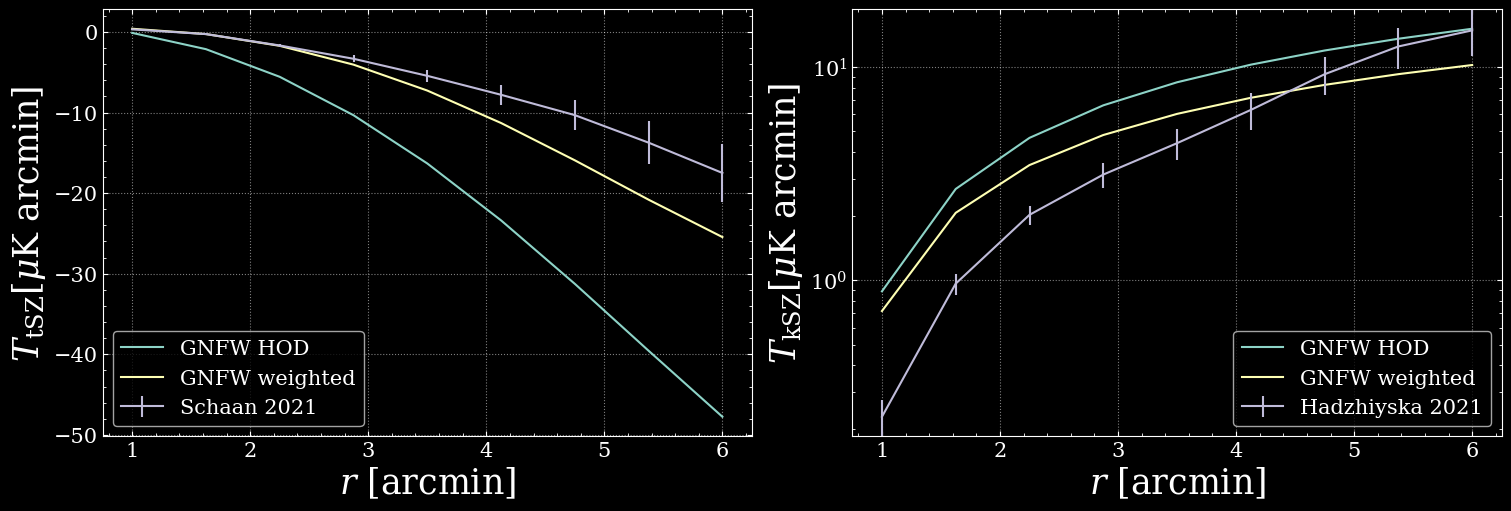

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
axs[0].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{tSZ} [\mu \text{K arcmin}]$')
axs[1].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{kSZ} [\mu \text{K arcmin}]$', yscale='log')

axs[0].plot(tSZmeas.thetas, tSZsign(aveprof_hod(Pth()))+tSZdust.dust_uKarcmin(tSZmeas.thetas, int(tSZmeas.freq))(), label='GNFW HOD')
axs[0].plot(tSZmeas.thetas, tSZsign(aveprof_dist(Pth()))+tSZdust.dust_uKarcmin(tSZmeas.thetas, int(tSZmeas.freq))(), label='GNFW weighted')
axs[0].errorbar(tSZmeas.thetas, tSZmeas.tSZdata, np.diag(tSZmeas.tSZcov)**0.5, label='Schaan 2021')

axs[1].plot(kSZmeas.thetas, kSZsign(aveprof_hod(rho())), label='GNFW HOD')
axs[1].plot(kSZmeas.thetas, kSZsign(aveprof_dist(rho())), label='GNFW weighted')
axs[1].errorbar(kSZmeas.thetas, kSZmeas.kSZdata, np.diag(kSZmeas.kSZcov)**0.5, label='Hadzhiyska 2021')

axs[0].plot(tSZmeas.thetas, tSZsign(pths_sim), label='Random Galaxy')
axs[1].plot(kSZmeas.thetas, kSZsign(rhos_sim), label='Random Galaxy')

axs[0].legend(), axs[1].legend(); plt.show()